# 0.0. Imports

In [3]:
import pandas              as pd
import numpy               as np
import seaborn             as sns
import xgboost             as xgb
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec
import inflection
import random
import warnings
import pickle

from scipy             import stats as ss
from boruta            import BorutaPy
from datetime          import datetime
from datetime          import timedelta
from IPython.display   import Image
from matplotlib.pyplot import figure


from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error

## 0.1. Helper Functions

In [4]:
warnings.filterwarnings( 'ignore' )

In [5]:
# Cramer V para calcular correlação entre variáveis categóricas
def cramer_v ( x, y ):
    cm = pd.crosstab( x, y ).values
    chi2 = ss.chi2_contingency( cm )[0]
    n = cm.sum()
    r, k = cm.shape #r é rows e K columns
    
    #precisamos corrigir o chi2, k e r para tirar o viés
    chi2corr = max( 0, chi2 - ( k-1 )*( r-1 )/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    v = np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )
    return(v)

In [6]:
def jupyter_settings():

    plt.rcParams['figure.figsize'] = [15, 8]
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None


In [7]:
jupyter_settings()

In [8]:
def mean_percentage_error (y, yhat):
    return np.mean( (y-yhat)/y )

In [9]:
def mean_absolute_percentage_error (y, yhat):
    return np.mean( np.abs( y-yhat )/y )

In [10]:
def ml_error (model_name, y, yhat):
    mae = mean_absolute_error( y, yhat ) 
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame({'Model name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])

In [11]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in (range (kfold, 0, -1)):
        if verbose:
            print(f'\nKFold Number: {k}')
        validation_start_date = x_training['date'].max() - timedelta( days = k*6*7 )
        validation_end_date = x_training['date'].max() - timedelta( days = (k-1)*6*7 )

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

        # training and validation dataset
        xtraining = training.drop(['sales', 'date'], axis=1)
        ytraining = training['sales']

        xvalidation = validation.drop(['sales', 'date'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # predict
        yhat = m.predict( xvalidation )

        #performance
        m_result = ml_error( model_name, np.exp(yvalidation), np.exp(yhat) )
        if verbose:
            print(m_result)

        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                        'CrossValidation MAE': np.round(np.mean(mae_list), 2).astype(str) + ' +- ' + np.round(np.std(mae_list), 2).astype(str),
                        'CrossValidation MAPE': np.round(np.mean(mape_list), 2).astype(str) + ' +- ' + np.round(np.std(mape_list), 2).astype(str),
                        'CrossValaidation RMSE': np.round(np.mean(rmse_list), 2).astype(str) + ' +- ' + np.round(np.std(rmse_list), 2).astype(str)},
                         index=[0])


## 0.2. Loading Data

In [12]:
df_sales_raw = pd.read_csv('rossmann/train.csv', low_memory=False)
df_store_raw = pd.read_csv('rossmann/store.csv', low_memory=False)

In [13]:
df_sales_raw.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [14]:
df_sales_raw.shape

(1017209, 9)

In [15]:
df_store_raw.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [16]:
df_store_raw.shape

(1115, 10)

In [17]:
df_raw = df_sales_raw.merge(df_store_raw, how='left', on='Store')
df_raw.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


# 1.0. Descrição dos Dados

In [18]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [19]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [20]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

In [21]:
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))    

In [22]:
cols_new

['store',
 'day_of_week',
 'date',
 'sales',
 'customers',
 'open',
 'promo',
 'state_holiday',
 'school_holiday',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_interval']

In [23]:
df1.columns = cols_new

## 1.2. Data Dimensions

In [24]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [25]:
# também dá para usar df1.dtypes
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   store                         1017209 non-null  int64  
 1   day_of_week                   1017209 non-null  int64  
 2   date                          1017209 non-null  object 
 3   sales                         1017209 non-null  int64  
 4   customers                     1017209 non-null  int64  
 5   open                          1017209 non-null  int64  
 6   promo                         1017209 non-null  int64  
 7   state_holiday                 1017209 non-null  object 
 8   school_holiday                1017209 non-null  int64  
 9   store_type                    1017209 non-null  object 
 10  assortment                    1017209 non-null  object 
 11  competition_distance          1014567 non-null  float64
 12  competition_open_since_month

In [26]:
# date está como objeto 
df1['date'] = pd.to_datetime(df1['date'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

## 1.4. Check NA

In [27]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA 

In [28]:
#competition_distance              2642
#competition_open_since_month    323348
#competition_open_since_year     323348
#promo2_since_week               508031
#promo2_since_year               508031
#promo_interval                  508031

In [29]:
#competition_distance: distância em metros do concorrente mais próximo

#hipótese para os NAs: o concorrente mais próximo pode estar tão longe que não temos essa informação
#vamos avaliar qual o valor máx dessa feature no nosso dataframe
df1['competition_distance'].max()

75860.0

In [30]:
#vamos substituir os NAs por um valor muito maior que o máximo, que é 75.860 m
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200_000 if pd.isna(x) else x)

In [31]:
#agora não temos mais valores nulos em competition_distance
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [32]:
#competition_open_since_month: data (mês) que o concorrente mais próximo abriu sua loja

#hipótese para os NAs: 
#    1. A loja abriu muito antes da nossa
#    2. A loja abriu depois e ninguém registrou
#    3. Não temos a loja mais próxima (competition_distance estava como nulo)

In [33]:
df1[pd.isna(df1['competition_open_since_month'])].head(2)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
11,12,5,2015-07-31,8959,962,1,1,0,1,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,5,2015-07-31,8821,568,1,1,0,0,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"


In [34]:
#assumption: se competition_open_since_month for nulo, vamos copiar o mês da coluna date
#vamos manter a coluna competition_open_since_month porque é uma boa variável para entender vendas de acordo com o tempo que tenho uma competição
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if pd.isna(x['competition_open_since_month']) else x['competition_open_since_month'],
                                               axis=1)


In [35]:
#competition_open_since_year: data (ano) que o concorrente mais próximo abriu sua loja
#assumption: o mesmo que fizemos para competition_open_since_month

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if pd.isna(x['competition_open_since_year']) else x['competition_open_since_year'],
                                               axis=1)

In [36]:
#promo2_since_week: promo2 é a continuação de uma promoção inicial e algumas lojas optaram por continuar ou não
#assumption: substituiremos pela data da coluna date

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if pd.isna(x['promo2_since_week']) else x['promo2_since_week'],
                                               axis=1)

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if pd.isna(x['promo2_since_year']) else x['promo2_since_year'],
                                               axis=1)

In [37]:
#promo_interval: os meses que a promo2 ficou ativa

month_map = {1 : 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

In [38]:
df1['promo_interval'].fillna(0, inplace=True)

In [39]:
df1['month_map'] = df1['date'].dt.month.map(month_map)

In [40]:
# comparando o mês da venda e os meses de promo_interval, sabemos se a venda faz parte da promo2
# precisamos comparar o month_map com a lista de meses do promo_interval
df1.sample(5).T

,94858,239624,61887,686461,457308
store,84,525,563,407,944
day_of_week,4,7,6,4,7
date,2015-05-07 00:00:00,2014-12-28 00:00:00,2015-06-06 00:00:00,2013-10-24 00:00:00,2014-05-18 00:00:00
sales,13679,0,4057,4153,0
customers,1386,0,560,325,0
open,1,0,1,1,0
promo,1,0,0,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,d,a,a,c


In [41]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else
                            1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [42]:
df1.sample(5).T

,188760,114514,126695,1006173,697417
store,326,785,701,114,213
day_of_week,4,1,4,4,1
date,2015-02-12 00:00:00,2015-04-20 00:00:00,2015-04-09 00:00:00,2013-01-10 00:00:00,2013-10-14 00:00:00
sales,4175,5051,3840,5304,7125
customers,396,503,472,571,643
open,1,1,1,1,1
promo,0,0,0,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,1,0,0
store_type,d,d,d,c,d


In [43]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change types

In [44]:
# competition_open_since_month, competition_open_since_year, promo2_since_week e promo2_since_year deveriam ser int
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

In [45]:
df1[['competition_open_since_month','competition_open_since_year','promo2_since_week','promo2_since_year']] = df1[['competition_open_since_month','competition_open_since_year','promo2_since_week','promo2_since_year']].apply(lambda x: x.astype('int64'))

## 1.7. Descriptive Statistical

In [46]:
# vamos separar nossas variáveis em numéricas e categóricas
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

In [47]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64']) 
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [48]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
472654,680,7,0,0,0,0,0,170.0,5,2014,1,35,2012,0
74169,580,2,9397,1542,1,0,0,170.0,2,2009,0,22,2015,0


In [49]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
351793,0,a,c,0,Aug
606888,0,a,c,0,Jan


## 1.7.1. Numerical Attributes

In [50]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis 
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() -x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='sales'>

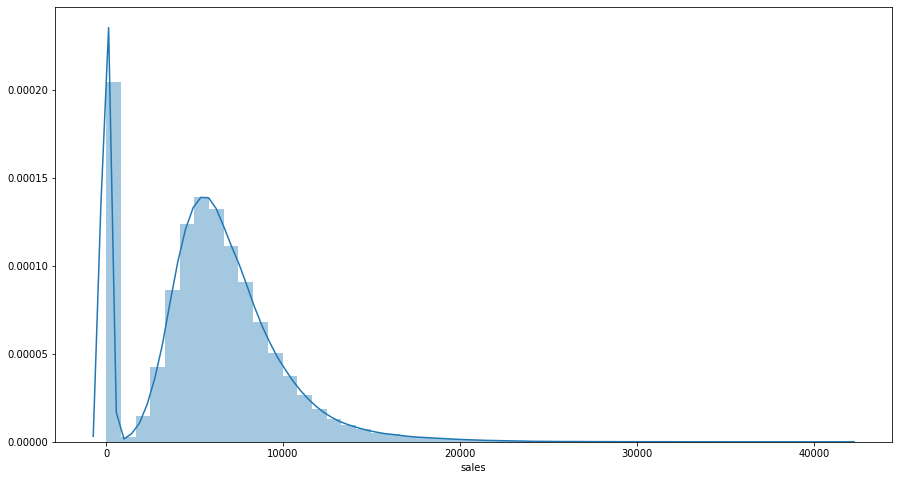

In [51]:
# avaliando Sales

# skew de 0.64: próxima a zero significa que é próxima a uma distribuição normal. Como é positiva, está deslocada para esquerda
# kustosis de 1.77: próxima a 1 significa que não tenho um pico muito grande

sns.distplot(df1['sales'])

<AxesSubplot:xlabel='competition_distance'>

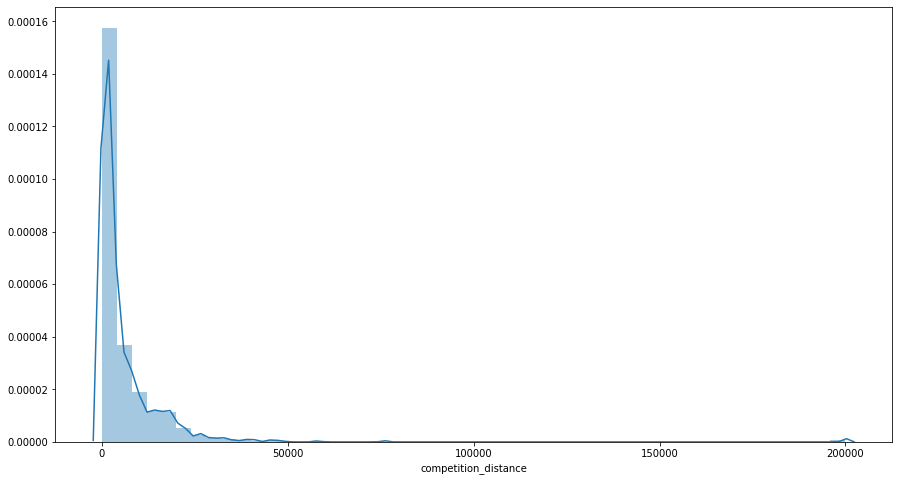

In [52]:
# avaliando competition_distance

# skew de 10: não é normal e está muito para esquerda (conseguimos ver isso através da média e mediana)
# kurtosis de 147: tem pico muito grande, muita concentração

sns.distplot(df1['competition_distance'])

In [53]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


## 1.7.2. Categorical Attributes

In [54]:
# quantas categorias temos para cada feature
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

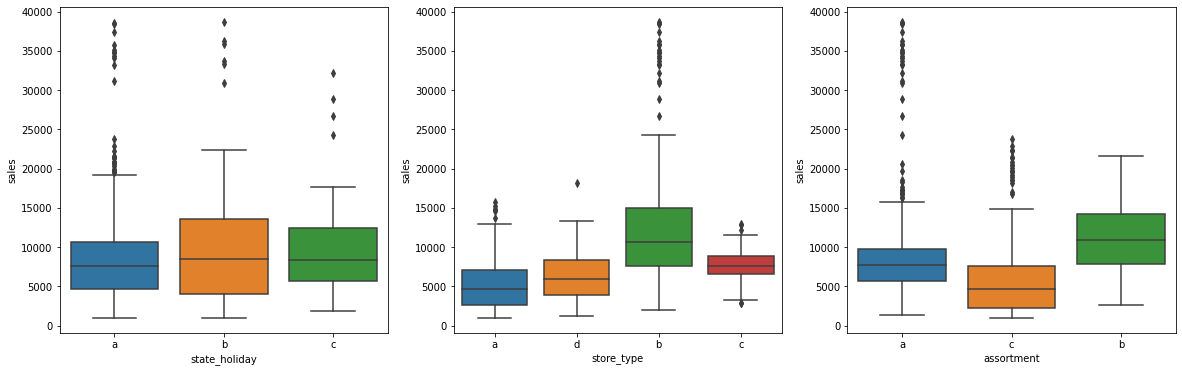

In [55]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

## 2.0. Passo 02 - Feature Engineering

In [56]:
df2 = df1.copy()

## 2.1. Mapa mental de hipóteses

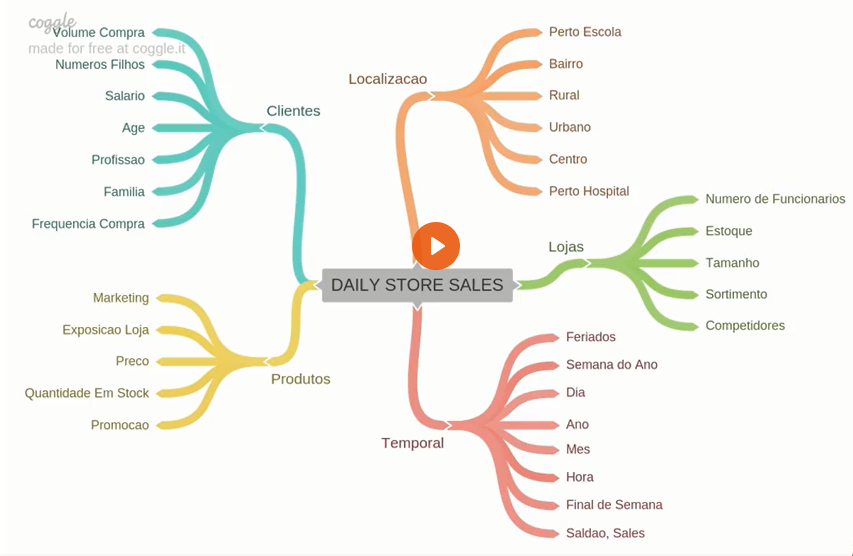

In [57]:
Image ('mindmap.png')

## 2.2. Criação das hipóteses

### 2.2.1. Hipóteses Loja

**1.** Loja com maior número de funcionários deveria vender mais

**2.** Loja com maior porte deveria vender mais

**3.** Loja com menor estoque deveria vender menos

**4.** Loja com maior sortimento deveria vender mais

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores há mais tempo deveriam vender mais

### 2.2.2. Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais

**2.** Lojas que expoem mais o produto na vitrine deveriam vender mais

**3.** Lojas que tem preço menor nos produtos deveriam vender mais

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.2.3. Hipóteses Tempo

**1.** Lojas que entram mais nos feriados deveriam vender menos

**2.** Lojas deveriam vender mais no primeiro semestre do ano

**3.** Lojas abertas durante o feriado de Natal deveriam vender mais

**4.** Lojas deveriam vender menos aos finais de semana

## 2.3. Lista final de hipóteses

In [58]:
# com base nos dados que temos

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores há mais tempo deveriam vender mais

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais promoções consecutivas deveriam vender mais

**6.** Lojas abertas durante o feriado de Natal deveriam vender mais

**7.** Lojas deveriam vender mais ao longo dos anos

**8.** Lojas deveriam vender mais no segundo semestre do ano

**9.** Lojas deveriam vender mais depois do dia 10 de cada mês

**10.** Lojas deveriam vender menos aos finais de semana

**11.** Lojas deveriam vender menos durante os feriados escolares

## 2.4. Feature Engineering

In [59]:
#year
df2['year'] = df2['date'].dt.year 

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year - week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.strptime(x + '-1', '%Y-%W-%w') - 
timedelta( days=7 ))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days)

#%w é dia da semana: 0 é domingo e 6 é sábado 

#assortment: a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else
                                                       'extra' if x == 'b' else
                                                       'extended')
#state holiday:  a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else
                                                             'easter_holiday' if x == 'b' else
                                                             'christmas' if x == 'c' else
                                                             'none')

In [60]:
df2.sample(5).T

,125562,210007,1013442,639643,756870
store,683,388,693,419,571
day_of_week,5,6,5,4,4
date,2015-04-10 00:00:00,2015-01-24 00:00:00,2013-01-04 00:00:00,2013-12-05 00:00:00,2013-08-22 00:00:00
sales,7216,7134,4802,7542,5624
customers,751,732,399,1043,455
open,1,1,1,1,1
promo,0,0,0,1,0
state_holiday,none,none,none,none,none
school_holiday,1,0,1,0,1
store_type,a,a,d,c,d


## 3.0. Parte 03 - Filtragem de variáveis

In [61]:
df3 = df2.copy()

In [62]:
# mostrar todas as colunas do dataframe
pd.set_option('display.max_columns', None)

In [63]:
df3.head(2)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,none,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,none,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279


## 3.1. Filtragem das linhas

In [64]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das colunas

In [65]:
# customer: não teremos essa info no momento da predição
df3.drop(['customers', 'open', 'promo_interval', 'month_map'], axis=1, inplace=True)

## 4.0. Parte 04 - Análise Exploratória dos Dados (EDA)

In [66]:
df4 = df3.copy()

### 4.1. Análise Univariada

### 4.1.1. Response Variable

In [67]:
# análise só da variável resposta (target)

<AxesSubplot:xlabel='sales'>

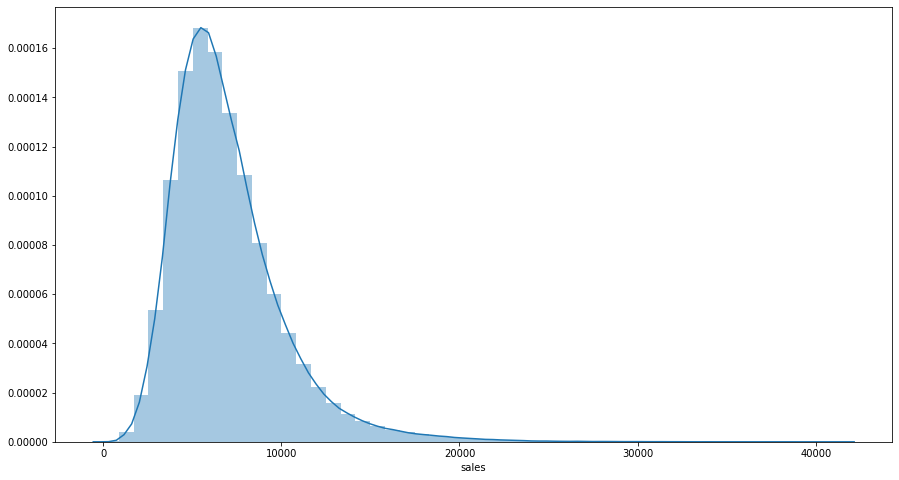

In [68]:
# é importante ver a distribuição da variável resposta, pq os algoritmos de ML partem da premissa que a distribuição é
# normal e as variáveis são independentes

sns.distplot(df4['sales'])

In [69]:
# skew próxima a zero significa próxima a uma distribuição normal
# skew mais para esquerda, então é positiva
df4['sales'].skew()

1.5949288357537479

In [70]:
# kurtosis próxima a 1 significa que não há um pico muito grande
df4['sales'].kurtosis()

4.854026585805923

<AxesSubplot:xlabel='sales'>

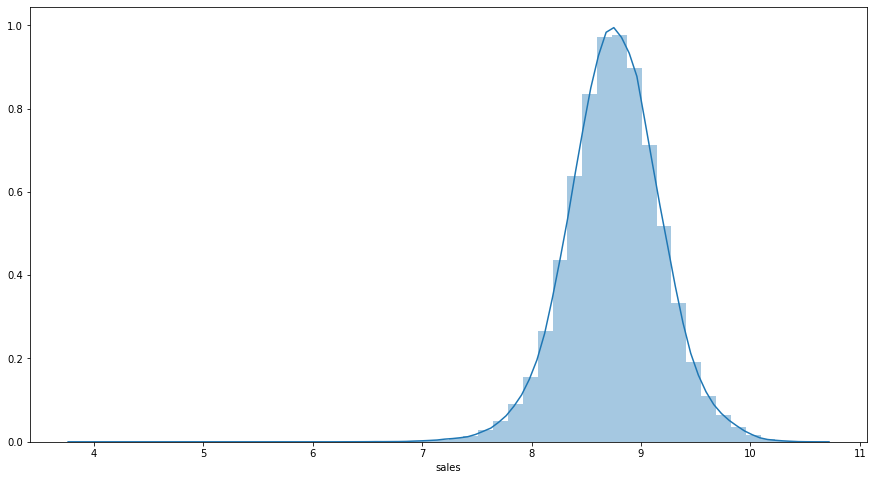

In [71]:
# uma transformação muito utilizada é a log para deixar a variável resposta numa distribuição normal
sns.distplot(np.log1p(df4['sales']))

In [72]:
np.log1p(df4['sales']).skew()

-0.10932694615869186

In [73]:
np.log1p(df4['sales']).kurtosis()

0.6538415711789693

### 4.1.2. Numerical Variable

array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'customers'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>,
        <AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>],
       [<AxesSubplot:title={'center':'competition_open_since_month'}>,
        <AxesSubplot:title={'center':'competition_open_since_year'}>,
        <AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>],
       [<AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'is_promo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

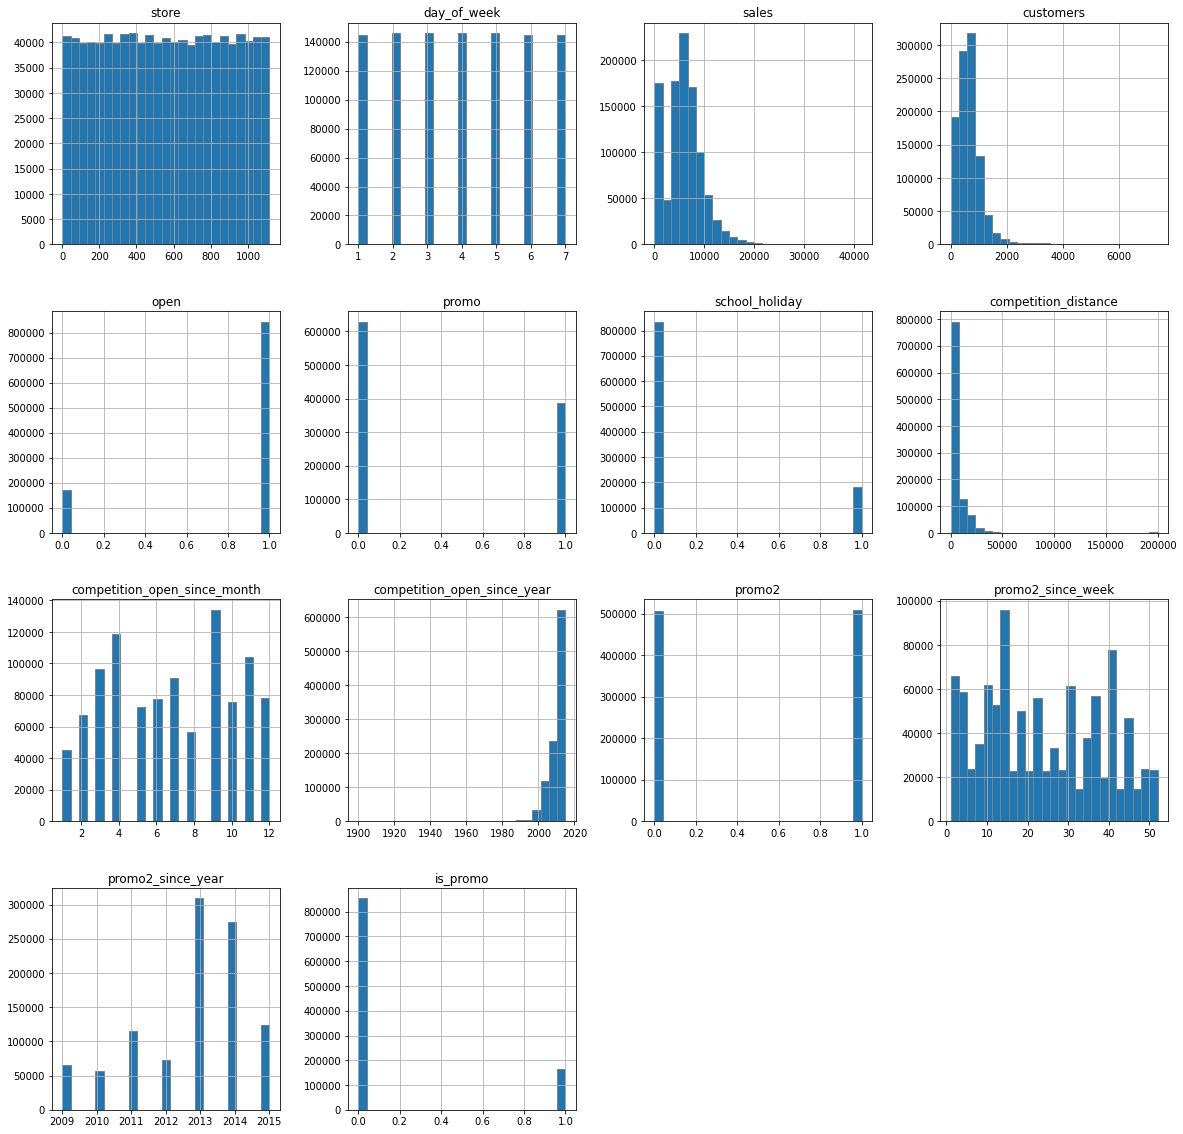

In [74]:
num_attributes.hist(figsize=(20,20), bins=25, ec='gray')

In [ ]:
num_attributes[num_attributes['open'] == 0]

In [ ]:
# Interpretando os gráficos acima: cada linha do dataframe é um registro diário de cada loja, portanto os histogramas de
# store e day_of_week não traz novas informações sobre os dados

# 1. Sales: o volume de vendas diário se concentra mais em aproximadamente 6.666 itens
# 2. Customers: o número de clientes diário se concentra mais em aproximadamente 857
# 3. Open: há mais dias em que as lojas ficam abertas ao invés de fechadas
# 4. Promo: há mais lojas que não aderiram à promo
# 5. School_holiday: há mais dias no período em que não é feriado escolar
# 6. Competition_distance: os concorrentes se concentram em distâncias mais próximas
# 7. Competition_open_since_month: concorrentes costumam abrir no mês 9 e mês 4
# 8. Competition_open_since_year: muitos concerrentes abriram em 2019
# 9. Promo2: as lojas que aderiram vs não aderiram à promo2 é de 50%/50%
# 10. Promo2_since_week: concentração de promo2 começando em algumas semanas do ano
# 11. Promo2_since_year: muitas começaram em 2013 e tivemos queda em 2014 e 2015
# 12. is_promo: a maioria das lojas não participaram de promoção 

### 4.1.3. Categorical Variable

In [ ]:
cat_attributes.head()

In [ ]:
# Vamos analisar apenas state_holiday, store_type e assortment
# Promo_interval e month_map são variável auxiliares que criamos  

In [ ]:
df4['state_holiday'].value_counts()

In [ ]:
# vamos tirar o none, pq ele é muito maior que os outros feriados, dificultando a interpretação do gráfico
a = df4[df4['state_holiday'] != 'none']
sns.countplot(a['state_holiday'])

In [ ]:
# Como public_holiday é o mais representativo, vamos analisar as vendas nesses dias
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

In [ ]:
# Apesar de termos menos dias de Natal comparando ao feriado de páscoa, as vendas no Natal são maiores

In [ ]:
# para deixar um gráfico do lado do outro

figure(figsize=(20,6))
plt.subplot(1, 2, 1) # 1 linha, 2 colunas, 1º gráfico
a = df4[df4['state_holiday'] != 'none']
sns.countplot(a['state_holiday'])

plt.subplot(1, 2, 2) # 1 linha, 2 colunas, 2º gráfico
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

In [ ]:
df4['store_type'].value_counts()

In [ ]:
df4['assortment'].value_counts()

In [ ]:
#store_type

figure(figsize=(20,12))
plt.subplot(2, 2, 1) 
sns.countplot(df4['store_type'])

plt.subplot(2, 2, 2)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment

plt.subplot(2, 2, 3) 
sns.countplot(df4['assortment'])

plt.subplot(2, 2, 4)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

### 4.2. Anália Bivariada

#### H1: Lojas com maior sortimento deveriam vender mais

In [ ]:
# de acordo com a descrição dos dados, estamos considerando que assortment extra tem maior sortimento e o basic tem menor

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

In [ ]:
# segundo o gráfico acima, nossa hipótese não é válida, mas e se no passado vendíamos muito no assortment extra e por 
# algum motivo tivemos mudança de comportamento ao longo do tempo?

In [ ]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux3 = aux2.pivot( index='year_week', columns='assortment', values='sales')

aux3.plot(figsize=(20,6))

aux4 = aux2[aux2['assortment'] == 'extra']
aux4 = aux4.pivot(index='year_week', columns='assortment', values='sales')
aux4.plot(figsize=(20,6))

In [ ]:
# apesar da linha extra do 1º gráfico parecer linear, quando platomas apenas ela, é possível identificar um comportamento

In [ ]:
# Conclusão: hipótese invalidada e comportamento diferente entre extra e basic + extended, portanto será uma feature relevante para o modelo

#### H2: Lojas com competidores mais próximos deveriam vender menos

In [ ]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

figure(figsize=(20,6))
sns.barplot(x='competition_distance', y='sales', data=aux1)

#dados muito granulares, não tá pra interpretar nada no gráfico
#vamos separar a distância em ranges de 1000 em 1000

In [ ]:
bins = list( np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux1.head()

In [ ]:
figure(figsize=(20,6))
sns.barplot(x='competition_distance_binned', y='sales', data=aux1)
plt.xticks(rotation=45);

In [ ]:
# Hipótese invalidada, pois temos maiores vendas em distâncias menores

In [ ]:
#outra visualização para dados muito granulares
figure(figsize=(20,6))
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

In [ ]:
#correlação entre competition_distance e sales
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### H3: Lojas com competidores há mais tempo deveriam vender mais

In [ ]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
#sns.barplot(x='competition_time_month', y='sales',data=aux1)
#gráfico está muito granular

figure(figsize=(20,6))
plt.subplot(1, 3, 1)
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales',data=aux2)
plt.xticks(rotation=90);
#pico próximo a zero significa que quanto mais recente é a competição, maior a venda

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales',data=aux2)
#linha de tendência

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True)

In [ ]:
#Hipótese invalidada porque lojas com competidores há mais tempo vendem menos

**H4: Lojas com promoções ativas por mais tempo deveriam vender mais**


In [ ]:
#se der promo time positivo é que minha venda aconteceu no período promocional extendido
#se der negativo, significa que minha venda ocorreu no período tradicional de promoção

In [ ]:
figure(figsize=(20,12))
grid = gridspec.GridSpec( 2 , 3 )
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
#sns.barplot(x='promo_time_week', y='sales', data=aux1)

#visualização muito ruim devido à granularidade dos dados, vamos separar em período tradicional de período extendido de promoção
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendido
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
plt.subplot( grid[0,0] )
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot( grid[0,1] )
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot( grid[1,0] )
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

plt.subplot( grid[1,1] )
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(), annot=True);

In [ ]:
# Hipótese invalidada: lojas com promoções ativas por mais tempo vendem mais até certo período, depois disso as vendas caem (1º gráfico)
# correlação muito fraca devido aos períodos constantes, mas pode ser relevante para o modelo combinada com outras features

**H5: Lojas com mais promoções consecutivas deveriam vender mais**

In [ ]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index().sort_values('sales', ascending=True)

In [ ]:
#não tem muita vantagem participar da promoção extendida
#maiores vendas quando participou apenas da promo1

In [ ]:
#vamos ver se o comportamento de quem participou da promo1 e da promo2 mudou ao longo do tempo
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize=(20,6))

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax )

ax.legend(labels = ['Tradicional & Extendida', 'Tradicional']);

In [ ]:
# Hipótese invalidada porque a linha azul do gráfico mostra menor volume de vendas e são lojas que aderiram à promoção extendida
# para o modelo, talvez não seja uma variável relevante, pq as curvas são parecidas quase em todo o período

**H6: Lojas abertas durante o feriado de Natal deveriam vender mais**

In [ ]:
aux1 = df4[df4['state_holiday'] != 'none']
aux1 = aux1[['state_holiday', 'sales','year']]

aux2 = aux1.groupby('state_holiday').sum().reset_index()
figure(figsize=(20,6))
plt.subplot(1, 2, 1)
sns.barplot(x='state_holiday', y='sales',data=aux2)

aux3 = aux1.groupby(['year', 'state_holiday']).sum().reset_index()
plt.subplot(1, 2, 2)
sns.barplot(x='year', y='sales', data=aux3, hue='state_holiday');

In [ ]:
#Hipótese invalidada: lojas abertas durante o Natal vendem menos

**H7: Lojas deveriam vender mais ao longo dos anos**

In [ ]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
figure(figsize=(20,6))
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);

In [ ]:
# tendência decrescente e corr de 0.98, mas o ano de 2015 ainda não acabou, mas ainda assim a hipótese foi invalidada

**H8: Lojas deveriam vender mais no segundo semestre do ano**

In [ ]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
figure(figsize=(20,6))
plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);

In [ ]:
#Hipótese invalidada porque lojas vendem menos no segundo semestre do ano

**H9:** Lojas deveriam vender mais depois do dia 10 de cada mês

In [ ]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
figure(figsize=(20,6))
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_day' if x<10 else
                                        'after_10_day')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2)


In [ ]:
# Hipótese verdadeira porque as lojas vendem mais depois do dia 10

**H10: Lojas deveriam vender menos aos finais de semana**

In [ ]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
figure(figsize=(20,6))
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True);

In [ ]:
# Hipótese verdadeira

**H11: Lojas deveriam vender menos durante os feriados escolares**

In [ ]:
df4.head()

In [ ]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
figure(figsize=(20,6))
plt.subplot(1, 2, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

aux2 = df4[['school_holiday', 'month', 'sales']].groupby(['school_holiday','month']).sum().reset_index()
plt.subplot(1, 2, 2)
sns.barplot(x='month', y='sales', data=aux2, hue='school_holiday')

In [ ]:
# Hipótese verdadeira, apesar dos meses de julho e agosto terem comportamento diferente

### 4.2.1 Resumo das hipóteses

In [ ]:
from tabulate import tabulate

In [2]:
tab = [['Hipóteses', 'Conclusão', 'Relevância para o modelo'], 
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Média'],
      ['H3', 'Falsa', 'Média'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', 'Falsa', 'Baixa'],
      ['H6', 'Falsa', 'Média'],
      ['H7', 'Falsa', 'Alta'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Verdadeira', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Baixa'],]
print( tabulate( tab, headers='firstrow' ) )

NameError: name 'tabulate' is not defined

### 4.3. Análise Multivariada

### 4.3.1. Numerical attributes

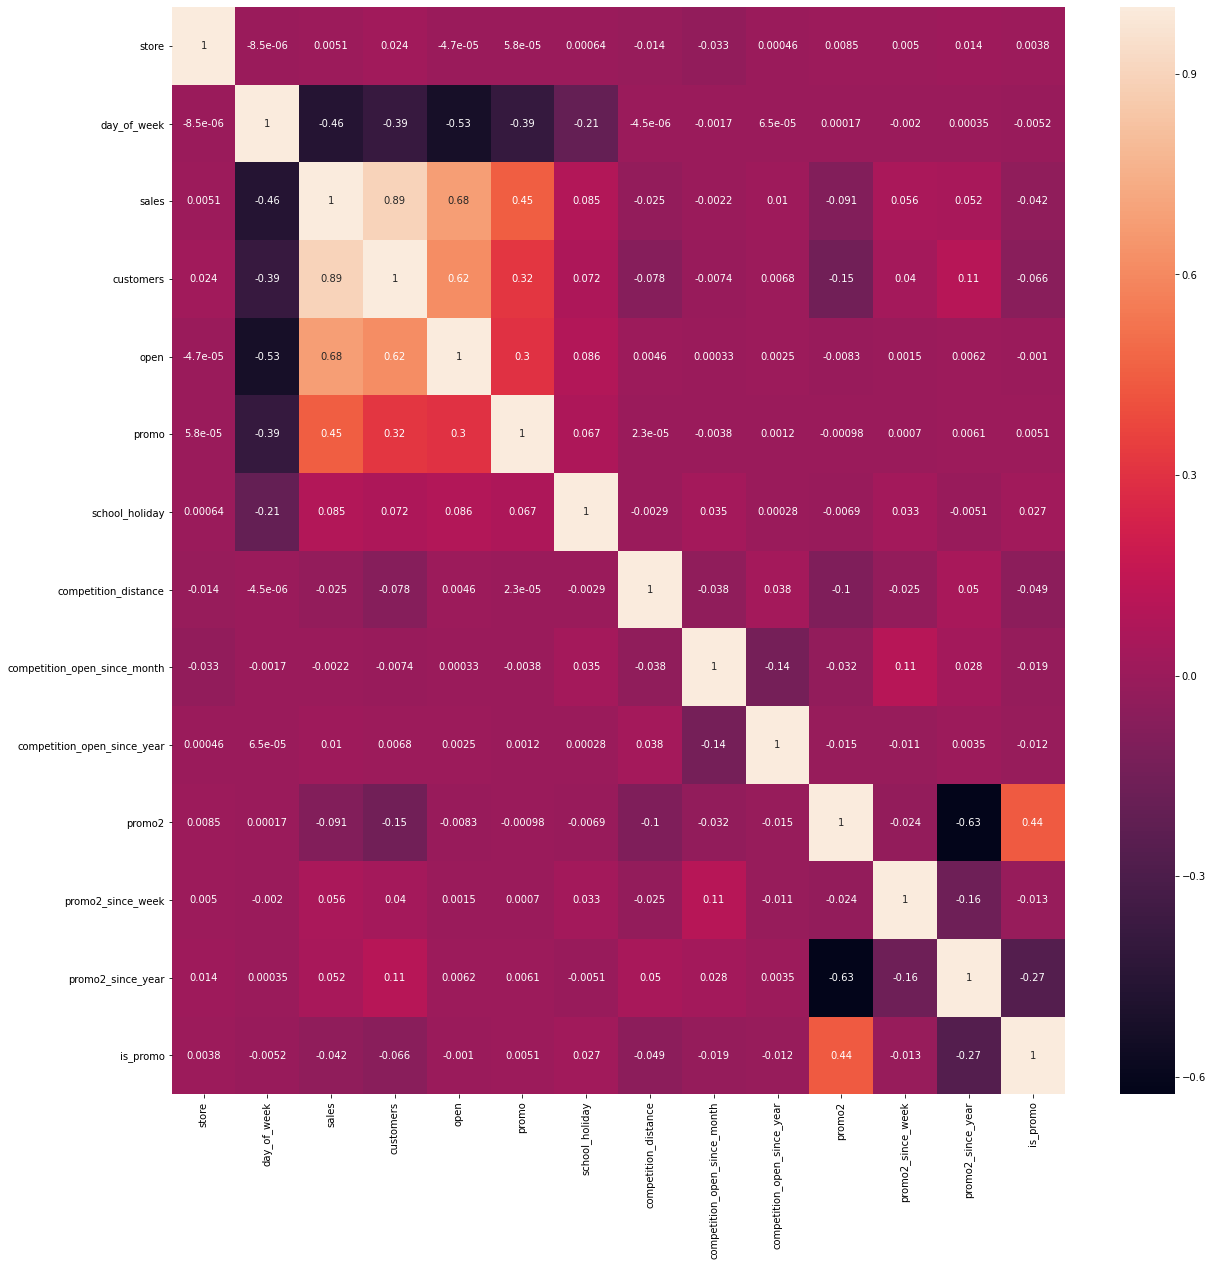

In [135]:
correlation = num_attributes.corr()
figure(figsize=(20,20))
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical attributes

In [136]:
# only categorical data
a = df4.select_dtypes( include='object' )

#calculate cramer v
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

#final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
             'store_type': [a4, a5, a6],
             'assortment': [a7, a8, a9]})

d = d.set_index( d.columns )

<AxesSubplot:>

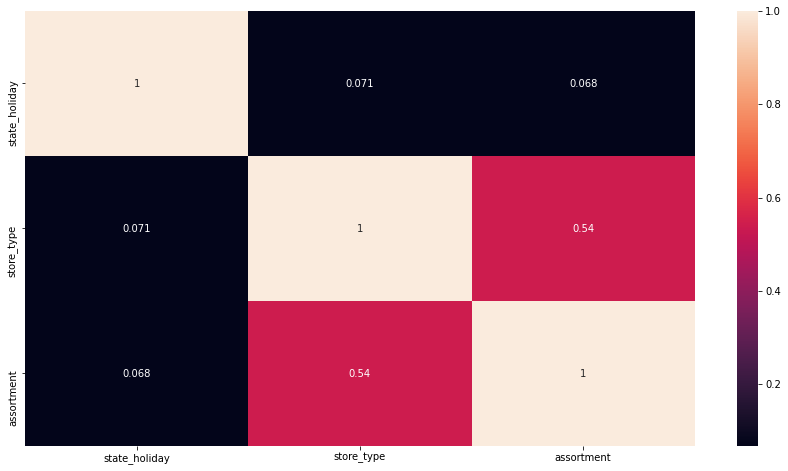

In [137]:
sns.heatmap(d, annot=True)

## 5.0 Data Preparation

In [210]:
df5 = df4.copy()

### 5.1. Normalização

In [139]:
# Na seção 4.1.2. vimos a distribuição de cada variável numérica e nenhuma delas é uma distribuição normal
# então não vamos normalizar, vamos usar o rescaling

### 5.2. Rescaling

In [140]:
df5['week_of_year'] = df5['week_of_year'].astype('int64')

In [141]:
a = df5.select_dtypes( include=['int64', 'float64'] )

In [142]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


In [143]:
# competition_distance
# year
# competition_time_month
# promo_time_week

<AxesSubplot:xlabel='promo_time_week'>

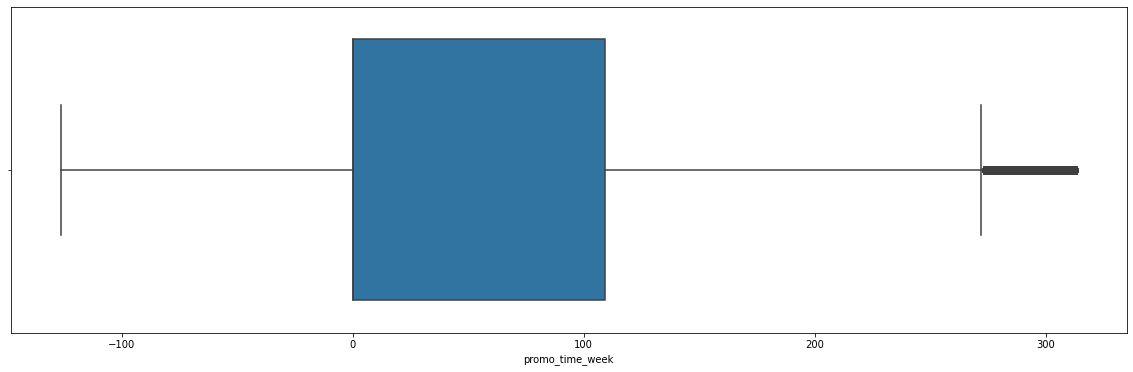

In [144]:
# Vamos identificar se temos outliers nas variáveis para optar pelo rescaling de min max ou o de Q1 e Q3

figure(figsize=(20,6))
sns.boxplot(df5['promo_time_week'])

In [208]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( r'C:\Users\aline.moraes\Documents\Aprendizado_continuo\Comunidade_DS\DS_em_producao\rossmann\parameter\competition_distance_scaler.pkl', 'wb' ) )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( r'C:\Users\aline.moraes\Documents\Aprendizado_continuo\Comunidade_DS\DS_em_producao\rossmann\parameter\competition_time_month_scaler.pkl', 'wb' ) )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( r'C:\Users\aline.moraes\Documents\Aprendizado_continuo\Comunidade_DS\DS_em_producao\rossmann\parameter\promo_time_week_scaler.pkl', 'wb' ) )

df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( r'C:\Users\aline.moraes\Documents\Aprendizado_continuo\Comunidade_DS\DS_em_producao\rossmann\parameter\year_scaler.pkl', 'wb' ))

<AxesSubplot:xlabel='competition_distance'>

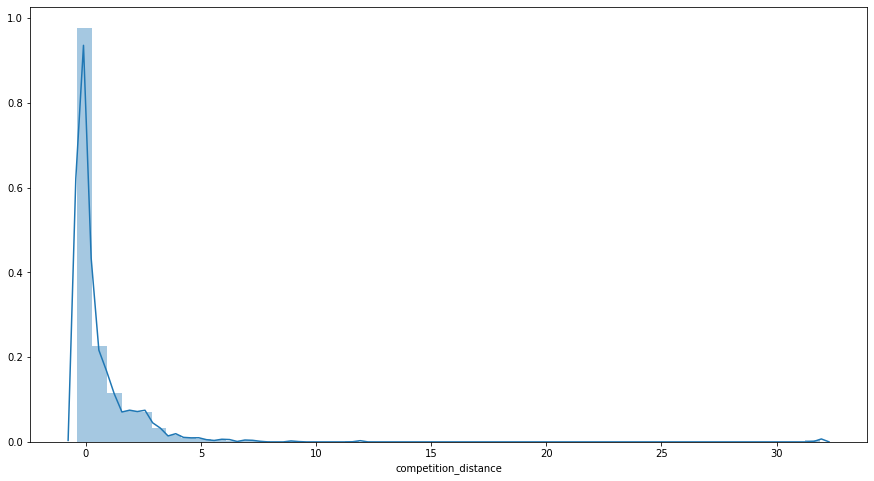

In [146]:
# vamos ver como as distribuições ficaram
sns.distplot( df5['competition_distance'] )

### 5.3. Transformação

### 5.3.1. Encoding

In [211]:
# state_holiday - One hot encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# story_type - Label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( r'C:\Users\aline.moraes\Documents\Aprendizado_continuo\Comunidade_DS\DS_em_producao\rossmann\parameter\store_type_scaler.pkl', 'wb' ) )

# assortment - Ordinal encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict ) 

### 5.3.2. Responsable variable transformation

In [148]:
df5['sales'] = np.log1p( df5['sales'] )

<AxesSubplot:xlabel='sales'>

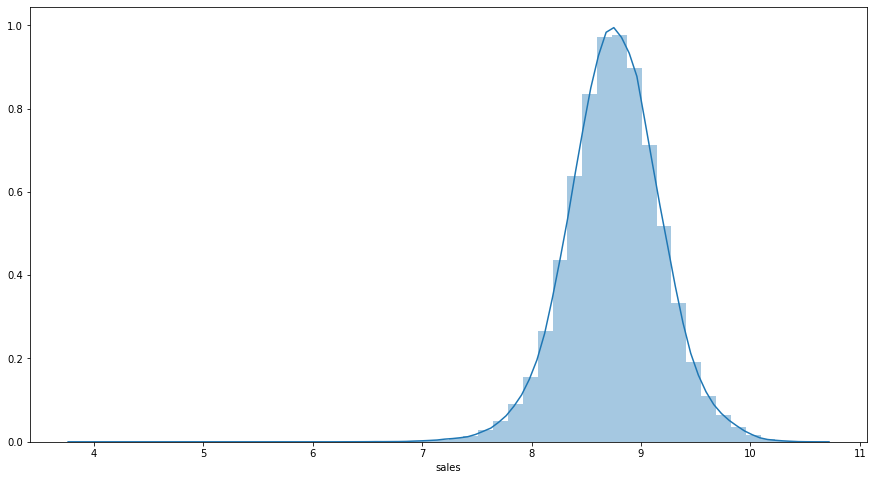

In [149]:
sns.distplot( df5['sales'] )

### 5.3.3. Nature Transformation

In [150]:
# São variáveis com natureza cíclica:

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x* (2* np.pi/12) ))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x* (2* np.pi/12) ))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x* (2* np.pi/30) ))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x* (2* np.pi/30) ))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x* (2* np.pi/7) ))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x* (2* np.pi/7) ))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x* (2* np.pi/52) ))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x* (2* np.pi/52) ))

In [151]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_none,state_holiday_public_holiday,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,1,0,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,1,0,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,1,0,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,1,0,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,1,0,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984


## 6.0 Feature Selection

In [152]:
df6 = df5.copy()

### 6.1. Split dataframe into traning and test dataset

In [153]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_none,state_holiday_public_holiday,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,1,0,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,1,0,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,1,0,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,1,0,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,1,0,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984


In [154]:
# como criamos features auxiliares para o modelo, vamos eliminar as originais
cols_drop = ['week_of_year', 'day_of_week', 'day', 'month', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [155]:
# vamos ver a data min e max para separamos as últimas 6 semanas e colocarmos no conjunto de teste

df6[['store', 'date']].groupby('store').max().reset_index().sort_values('store')['date'][0] - timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [156]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']


a = X_train['date'].min()
b = X_train['date'].max()
c = X_test['date'].min()
d = X_test['date'].max()
print(f'Training min date: {a}')
print(f'Training max date: {b}')
print(f'\nTest min date: {c}')
print(f'Test max date: {d}')

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


### 6.2. Boruta as feature selector

In [157]:
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values # para ficar no formato de vetor
#y_train_n = y_train.values.ravel() # formato de vetor 

# define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 ) # n_jobs=-1 para usar todos os cores da máquina para processar mais rápido

# define boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1. Best features from Boruta

In [158]:
#cols_selected = boruta.support_.tolist()

#X_train_fs = X_train.drop(['date','sales'], axis=1)

In [159]:
#cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.tolist()

#cols_not_selected_boruta = list(set(X_train_fs.columns) - set(cols_selected_boruta))

In [160]:
#cols_selected_boruta

In [161]:
#cols_not_selected_boruta

### 6.3. Manual Feature Selection

In [162]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'month_cos',
                        'month_sin',
                        'day_sin',
                        'day_cos',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'week_of_year_cos',
                       'week_of_year_sin'] # incluimos os senos que faltaram

# cols to add
feat_to_add = ['sales', 'date']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

## 7.0 Machine Learning Modelling

In [163]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

In [164]:
x_training = X_train[cols_selected_boruta_full]

### 7.1. Average model

In [165]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns={'sales': 'prediction'} )
aux1 = aux1.merge(aux2, how='left', on='store')
yhat_baseline = aux1['prediction']

# performance
baseline_result = ml_error( 'Average Model', np.exp(y_test), np.exp(yhat_baseline) ) # na seção 5.3.2. transformamos a variável resposta em log, então precisamos voltar
baseline_result

,Model name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.454952,1835.135542


### 7.2. Linear Regression Model

In [166]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.exp(y_test), np.exp(yhat_lr) )
lr_result

,Model name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292628,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [167]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,CrossValidation MAE,CrossValidation MAPE,CrossValaidation RMSE
0,Linear Regression,2081.73 +- 295.63,0.3 +- 0.02,2952.52 +- 468.37


### 7.3. Linear Regression Regularized Model - Lasso

In [168]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train ) # alpha é o fator multiplicativo dos pesos, menor alpha dá resultados melhores

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.exp(y_test), np.exp(yhat_lrr) )
lrr_result

,Model name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289041,2744.451735


In [169]:
# Como o RMSE deu mto alto nos modelos de regressão, significa que nosso problema não é linear

### 7.3.1. Lasso - Cross Validation

In [170]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,CrossValidation MAE,CrossValidation MAPE,CrossValaidation RMSE
0,Lasso,2116.38 +- 341.5,0.29 +- 0.01,3057.75 +- 504.26


### 7.4. Random Forest Regressor

In [171]:
# model
#rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train ) # alpha é o fator multiplicativo dos pesos, menor alpha dá resultados melhores

# prediction
#yhat_rf = rf.predict( x_test )

# performance
#rf_result = ml_error( 'Random Forest Regressor', np.exp(y_test), np.exp(yhat_rf) )
#rf_result

,Model name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.626224,0.099788,1009.441713


### 7.4.1 Random Forest Regressor - Cross Validation

In [172]:
#rf_result_cv = cross_validation( x_training, 5, 'Random Forest', rf, verbose=False )
#rf_result_cv

,Model Name,CrossValidation MAE,CrossValidation MAPE,CrossValaidation RMSE
0,Random Forest,837.78 +- 218.38,0.12 +- 0.02,1256.5 +- 319.25


### 7.5. XGBoost Regressor

In [174]:
# model
#model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                            n_estimators=100,
#                            eta=0.01,
#                            max_depth=100,
#                            subsample=0.7,
#                            colsample_bytee=0.9).fit( x_train, y_train ) # alpha é o fator multiplicativo dos pesos, menor alpha dá resultados melhores

# prediction
#yhat_xgb = model_xgb.predict( x_test )

# performance
#xgb_result = ml_error( 'XGBoost Regressor', np.exp(y_test), np.exp(yhat_xgb) )
#xgb_result

,Model name,MAE,MAPE,RMSE
0,XGBoost Regressor,723.054492,0.103301,1042.521917


### 7.5.1. XGBoost Regressor - Cross Validation

In [175]:
#xgb_result_cv = cross_validation( x_training, 5, 'XGBoost', model_xgb, verbose=True )
#xgb_result_cv


KFold Number: 5
  Model name          MAE      MAPE         RMSE
0    XGBoost  1187.152128  0.151908  1701.056107

KFold Number: 4
  Model name         MAE      MAPE         RMSE
0    XGBoost  817.706046  0.122493  1160.140468

KFold Number: 3
  Model name         MAE      MAPE        RMSE
0    XGBoost  669.984378  0.103924  986.768212

KFold Number: 2
  Model name          MAE      MAPE         RMSE
0    XGBoost  1024.059745  0.132799  1509.600472

KFold Number: 1
  Model name         MAE      MAPE         RMSE
0    XGBoost  846.697242  0.115934  1196.217105


,Model Name,CrossValidation MAE,CrossValidation MAPE,CrossValaidation RMSE
0,XGBoost,909.12 +- 178.86,0.13 +- 0.02,1310.76 +- 257.93


### 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [176]:
#modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
#modelling_result.sort_values( 'RMSE' )

,Model name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.626224,0.099788,1009.441713
0,XGBoost Regressor,723.054492,0.103301,1042.521917
0,Average Model,1354.800353,0.454952,1835.135542
0,Linear Regression,1867.089774,0.292628,2671.049215
0,Linear Regression - Lasso,1891.704880,0.289041,2744.451735


In [183]:
tab = [['Model name', 'MAE', 'MAPE', 'RMSE'], 
      ['Random Forest Regressor', 678.626224, 0.099788, 1009.441713],
      ['XGBoost Regressor', 723.054492, 0.103301, 1042.521917],
      ['Average Model', 1354.800353, 0.454952, 1835.135542],
      ['Linear Regression', 1867.089774, 0.292628, 2671.049215],
      ['Linear Regression - Lasso', 1891.704880, 0.289041, 2744.451735],]
print( tabulate( tab, headers='firstrow' ) )

Model name                      MAE      MAPE     RMSE
-------------------------  --------  --------  -------
Random Forest Regressor     678.626  0.099788  1009.44
XGBoost Regressor           723.054  0.103301  1042.52
Average Model              1354.8    0.454952  1835.14
Linear Regression          1867.09   0.292628  2671.05
Linear Regression - Lasso  1891.7    0.289041  2744.45


### 7.6.1. Real Performance - Cross Validation

In [177]:
#modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
#modelling_result_cv

,Model Name,CrossValidation MAE,CrossValidation MAPE,CrossValaidation RMSE
0,Linear Regression,2081.73 +- 295.63,0.3 +- 0.02,2952.52 +- 468.37
0,Lasso,2116.38 +- 341.5,0.29 +- 0.01,3057.75 +- 504.26
0,Random Forest,837.78 +- 218.38,0.12 +- 0.02,1256.5 +- 319.25
0,XGBoost,909.12 +- 178.86,0.13 +- 0.02,1310.76 +- 257.93


In [178]:
# apesar do Random Forest ter menor erro, vamos seguir com o XGBoost pq esse último costuma gastar menos tempo de processamento

In [184]:
tab = [['Model name', 'CrossValidation MAE', 'CrossValidation MAPE', 'CrossValidation RMSE'], 
      ['Linear Regression', '2081.73 +- 295.63', '0.3 +- 0.02', '2952.52 +- 468.37'],
      ['Lasso', '2116.38 +- 341.5', '0.29 +- 0.01', '3057.75 +- 504.26'],
      ['Random Forest', '837.78 +- 218.38', '0.12 +- 0.02', '1256.5 +- 319.25'],
      ['XGBoost', '909.12 +- 178.86', '0.13 +- 0.02', '1310.76 +- 257.93'],]
print( tabulate( tab, headers='firstrow' ) )

Model name         CrossValidation MAE    CrossValidation MAPE    CrossValidation RMSE
-----------------  ---------------------  ----------------------  ----------------------
Linear Regression  2081.73 +- 295.63      0.3 +- 0.02             2952.52 +- 468.37
Lasso              2116.38 +- 341.5       0.29 +- 0.01            3057.75 +- 504.26
Random Forest      837.78 +- 218.38       0.12 +- 0.02            1256.5 +- 319.25
XGBoost            909.12 +- 178.86       0.13 +- 0.02            1310.76 +- 257.93


## 8.0. Hyper Parameter Fine Tuning

### 8.1. Random Search

In [ ]:
#param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
#        'eta': [0.01, 0.03],
#        'max_depth': [3, 5, 9],
#        'subsample': [0.1, 0.5, 0.7],
#        'colsample_bytee': [0.3, 0.7, 0.9],
#        'min_child_weight': [3, 8, 15]}

#max_eval = 5

In [ ]:
#final_result = pd.DataFrame()

#for i in range ( max_eval ):
    # choose values for parameters randomly
#    hp = {k: random.sample( v, 1 )[0] for k, v in param.items()} #para pegar as chaves e os valores do dicionário
#    print(hp)

    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                n_estimators=hp['n_estimators'],
                                eta=hp['eta'],
                                max_depth=hp['max_depth'],
                                subsample=hp['subsample'],
                                colsample_bytee=hp['colsample_bytee'],
                                min_child_weight=hp['min_child_weight']) # não precisamos treinar o modelo aqui, pq treinaremos dentro da função de Cross Validation


    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )
#    final_result = pd.concat( [final_result, result] )

#final_result

### 8.2. Final Model

In [185]:
# iteração 1 e 5 com os menores erros. Ficaremos com a 5 pq a profundidade da árvore é menor
param_tuned = {'n_estimators':3500,
        'eta': 0.01,
        'max_depth': 5,
        'subsample': 0.5,
        'colsample_bytee': 0.7,
        'min_child_weight': 15}

In [186]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                            n_estimators=param_tuned['n_estimators'],
                            eta=param_tuned['eta'],
                            max_depth=param_tuned['max_depth'],
                            subsample=param_tuned['subsample'],
                            colsample_bytee=param_tuned['colsample_bytee'],
                            min_child_weight=param_tuned['min_child_weight']).fit( x_train, y_train )

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )


# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.exp(y_test), np.exp(yhat_xgb_tuned) )
xgb_result_tuned

,Model name,MAE,MAPE,RMSE
0,XGBoost Regressor,656.439978,0.096048,954.96594


In [187]:
mpe = mean_percentage_error(np.exp(y_test), np.exp(yhat_xgb_tuned))
mpe #valores negativos eu to superestimando os dados. Ex: salário real 1, predição 9 então 1-9=-8

-0.0024906664103430095

In [190]:
tab = [['Model name', 'MAE', 'MAPE', 'RMSE', 'MPE'], 
      ['XGBoost Regressor', 656.439978, 0.096048, 954.96594, -0.002491],]
print( tabulate( tab, headers='firstrow' ) )

Model name            MAE      MAPE     RMSE        MPE
-----------------  ------  --------  -------  ---------
XGBoost Regressor  656.44  0.096048  954.966  -0.002491


## 9.0. Tradução e Interpretação do Erro

In [193]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.exp(df9['sales'])
df9['predictions'] = np.exp(yhat_xgb_tuned)

### 9.1. Business Performance

In [194]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] )).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] )).reset_index().rename(columns={0: 'MAPE'})

# Merge
df9_aux3 = df9_aux1.merge(df9_aux2, how='inner', on='store')
df92 = df91.merge(df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [195]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104058.453125,100755.962762,107360.943488,3302.490363,0.556364
908,909,249703.437500,242218.139330,257188.735670,7485.298170,0.520694
594,595,336553.031250,331345.004896,341761.057604,5208.026354,0.358800
875,876,202282.578125,198394.640774,206170.515476,3887.937351,0.303467
721,722,360242.312500,358055.574060,362429.050940,2186.738440,0.292319


<AxesSubplot:xlabel='store', ylabel='MAPE'>

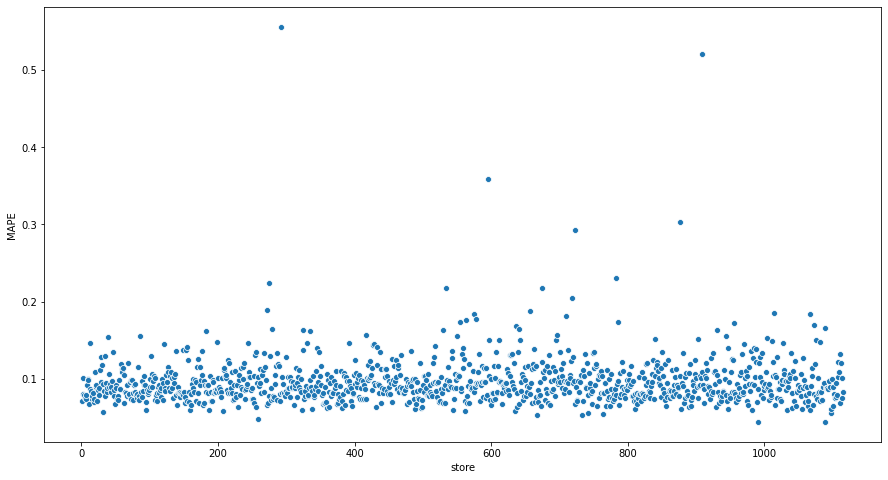

In [196]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

### 9.2. Total Performance

In [201]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum( x ), axis=0).reset_index().rename(columns={'index': 'Scenarios', 0: 'Values'})
df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format)
df93

,Scenarios,Values
0,predictions,"R$ 285,666,048.00"
1,worst_scenario,"R$ 284,930,321.69"
2,best_scenario,"R$ 286,401,745.84"


### 9.3. Machine Learning Performance

In [202]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

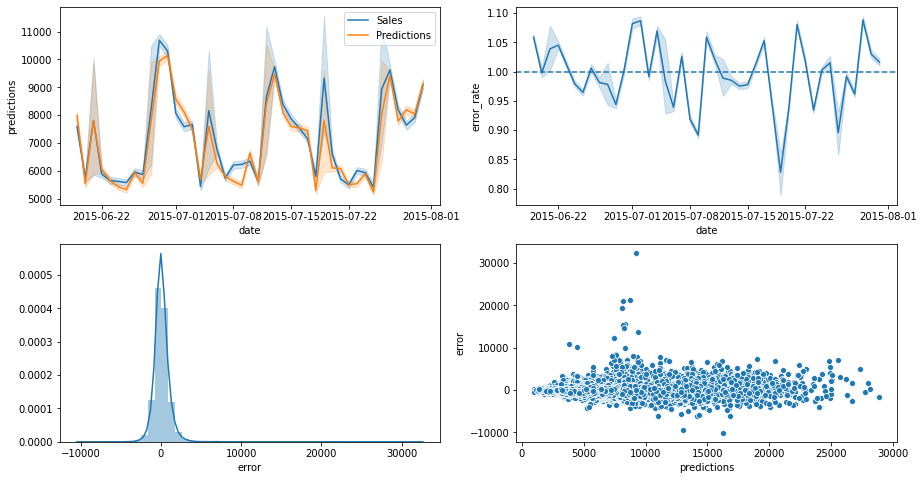

In [204]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='Sales' )
sns.lineplot( x='date', y='predictions', data=df9, label='Predictions' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--' )

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

## 10.0. Save Model

In [206]:
pickle.dump( model_xgb_tuned, open( r'C:\Users\aline.moraes\Documents\Aprendizado_continuo\Comunidade_DS\DS_em_producao\rossmann\model\model_rossmann.pkl', 'wb' ))